In [175]:
#Importamos todas las librerias que vamos a usar
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [262]:
#cargamos el dataset
df_fraude = pd.read_csv('fraude_tc.csv')


In [4]:
df_fraude.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

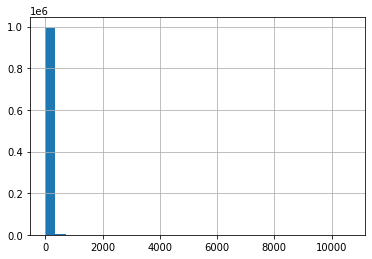

In [5]:
df_fraude['distance_from_home'].hist(bins=30)

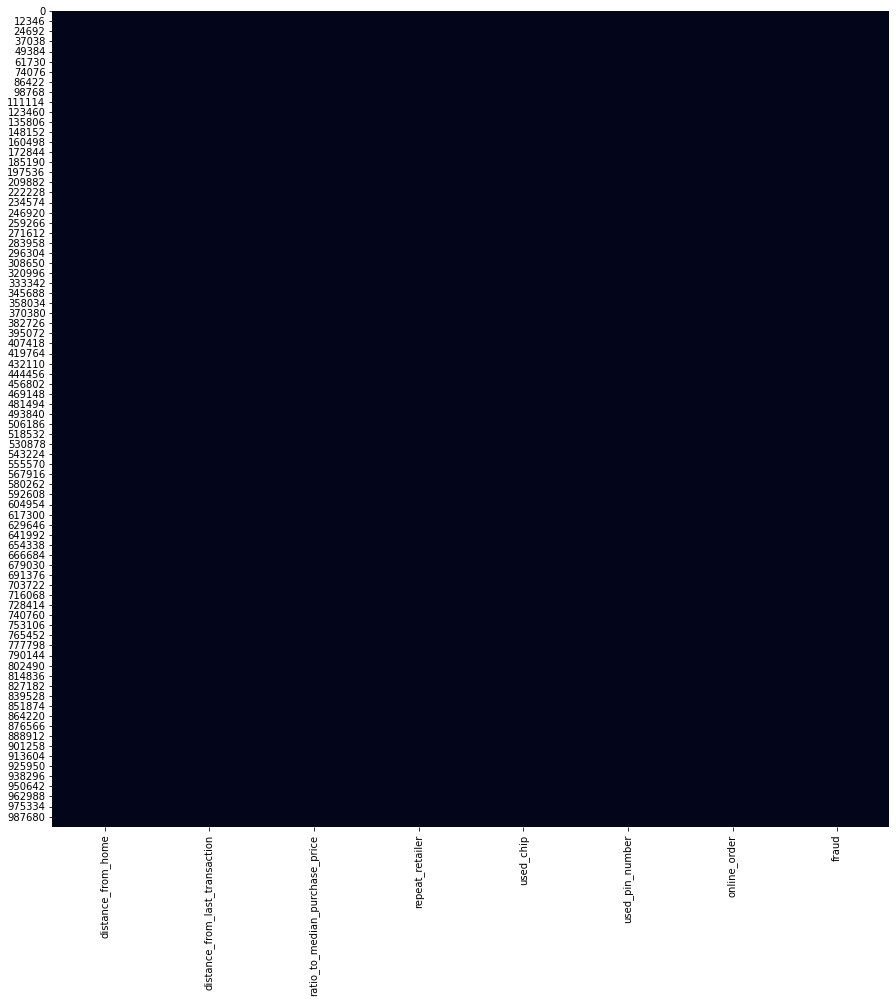

In [6]:
#Observamos graficamente los valores nulos
fig = plt.figure(figsize=(15,15))
sns.heatmap(df_fraude.isnull(), cbar=False)
plt.show()

Se puede observar que el dataframe no tiene nulos

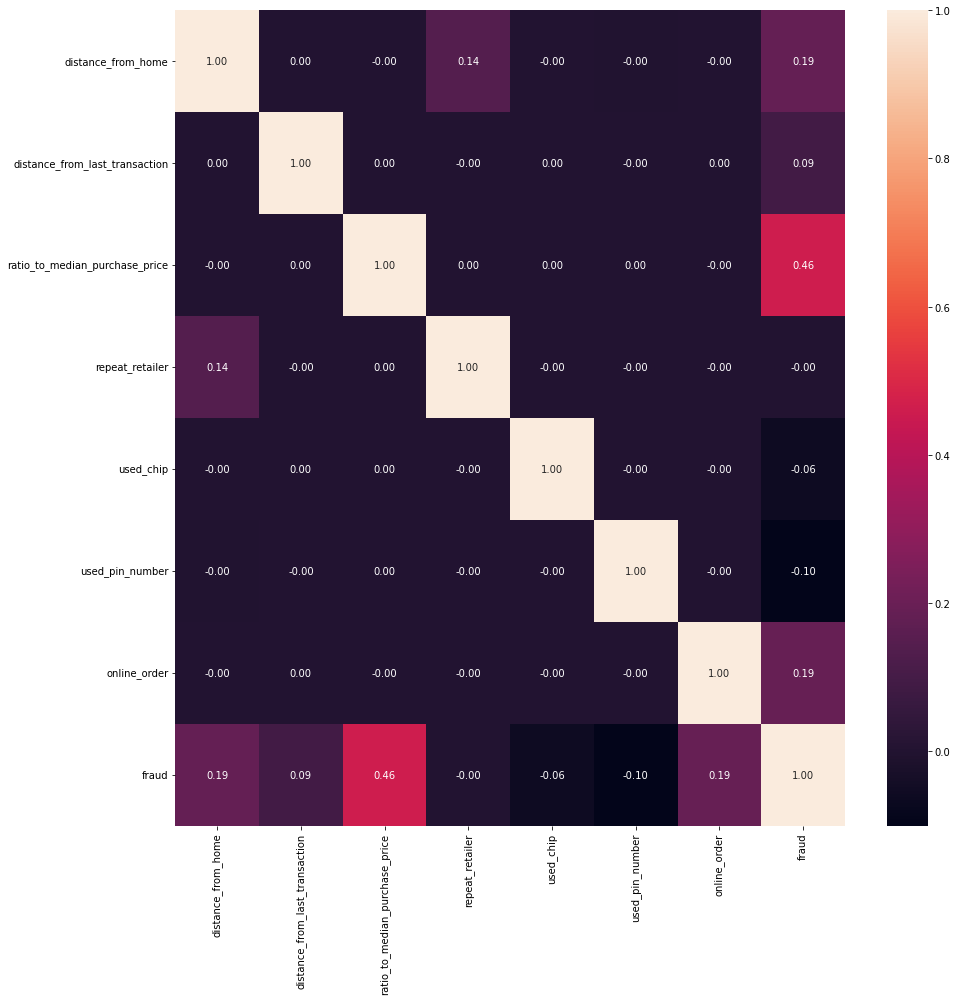

In [7]:
#graficamos el heatmap de la matriz de correlacion
fig = plt.figure(figsize=(15,15))
sns.heatmap(df_fraude.corr(), cbar=True, annot=True, fmt='.2f')
plt.show()

In [8]:
df_fraude.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


Existen inconsistencias en los datos, tenemos transacciones on line y transacciones con chip simultaneas que son fraudulentas y que no lo son.

In [263]:
df_fraude[(df_fraude.online_order == 1) & (df_fraude.used_chip == 1) & (df_fraude.fraud == 1)] 

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
35,26.711462,1.552008,4.603601,1.0,1.0,0.0,1.0,1.0
268,5.764412,0.624542,8.565935,1.0,1.0,0.0,1.0,1.0
269,7.230067,4.029309,5.746112,1.0,1.0,0.0,1.0,1.0
292,24.337488,1.398618,6.230792,1.0,1.0,0.0,1.0,1.0
338,12.750895,0.857614,17.706145,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
999811,1.738038,0.134839,10.117408,0.0,1.0,0.0,1.0,1.0
999830,4.000970,0.095762,4.149602,1.0,1.0,0.0,1.0,1.0
999834,12.397805,7.300905,8.433401,1.0,1.0,0.0,1.0,1.0
999883,14.850909,7.218322,10.680334,1.0,1.0,0.0,1.0,1.0


In [264]:
df_fraude[(df_fraude.online_order == 1) & (df_fraude.used_chip == 1) & (df_fraude.fraud == 0)].shape 

(206304, 8)

### Este es un problema de clasificacion asi que veremos el rendimiento del modelo RandomForestClassifier

Pasos
1- Limpieza de datos
2- Observar los datos graficamente 
3- Escalado de los datos 
4- Verificacion de los resultados del escalado
5- Aplicacion del modelo 


## 1- Limpieza de datos

In [265]:
#Vamos a ver cuantos fraudes con valores igual a 1 hay en el dataset
df_fraude[(df_fraude.fraud == 1)].shape[0]

87403

In [266]:
#Vamos a ver cuantos fraudes con valores igual a 1 hay en el dataset
df_fraude[(df_fraude.fraud == 0)].shape[0]

912597

En el dataframe nos encontramos con casos donde se hicieron compras con chip (con la tarjeta de debito/credito con chip) y compras online que nos indican como fraudulentas, en estos casos suponemos que el fraude posivo en el dataset,  esto es inconsistente y eliminamos estos registros.

In [267]:
#Vamos a ver cuantos fraudes con incoherencias tenemos en el dataset
df_fraude[(df_fraude.online_order == 1) & (df_fraude.used_chip == 1) & (df_fraude.fraud == 1)].shape[0]

21599

In [268]:
#Creamos una mascara para ver los fraudes que vamos a eliminar
mask_1 =df_fraude[(df_fraude.online_order == 1) & (df_fraude.used_chip == 1) & (df_fraude.fraud == 1)]

In [269]:
#Eliminamos del dataset los datos de los fraudes inconsistentes
df_fraude_clean = df_fraude.drop(mask_1.index)


In [270]:
#Creamos una mascara para ver las inconsistencias que vamos a eliminar
mask_0 =df_fraude[(df_fraude.online_order == 1) & (df_fraude.used_chip == 1) & (df_fraude.fraud == 0)]

In [271]:
#Eliminamos del dataset  los datos inconsistentes
df_fraude_clean = df_fraude.drop(mask_0.index)

In [272]:
df_fraude_clean.shape

(793696, 8)

In [273]:
#Vamos a ver cuantos fraudes con valores igual a 1 quedan en el dataset
df_fraude_clean[(df_fraude_clean.fraud == 0)].shape[0]

706293

## 2- Observar los datos graficamente 

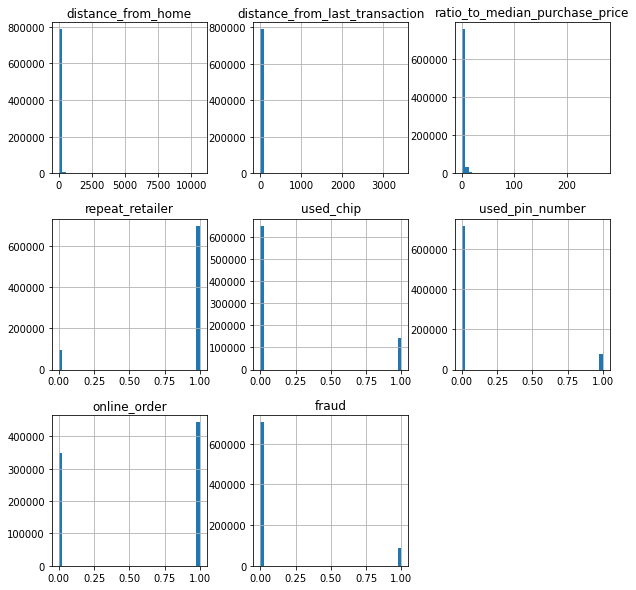

In [274]:
#Vamos a observar los histogramas  de las variables que nos interesan
df_fraude_clean.hist(bins=40,figsize=(10,10))
plt.show()

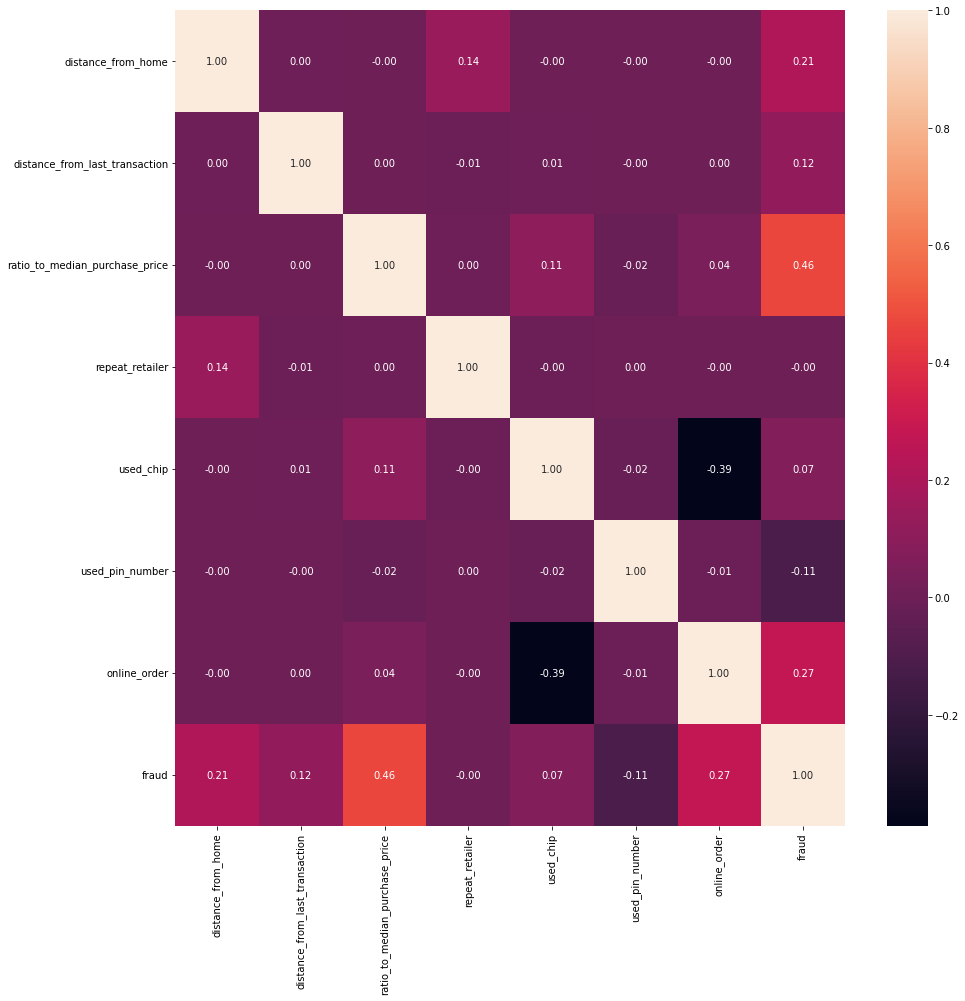

In [275]:
#graficamos el heatmap de la matriz de correlacion
fig = plt.figure(figsize=(15,15))
sns.heatmap(df_fraude_clean.corr(), cbar=True, annot=True, fmt='.2f')
plt.show()

In [276]:
df_fraude_clean.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0


Podemos observar que las caracteristicas con mas correlacion son "distance_from_home" , "distance_from_last_transaction", "ratio_to_median_purchase_price", "used_chip" y "online_order".

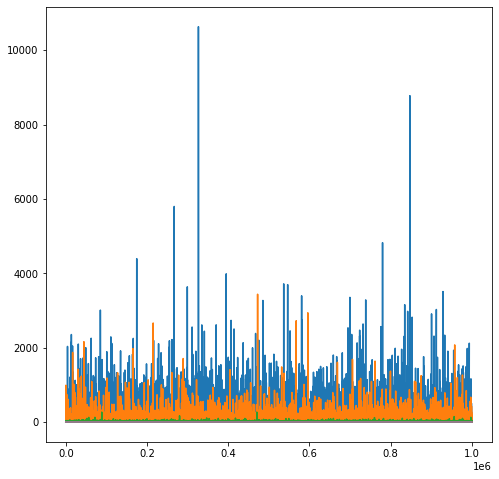

In [277]:
#vamos a graficar los datos del dataframe
fig = plt.figure(figsize=(8,8))
plt.plot(df_fraude_clean)
plt.show()

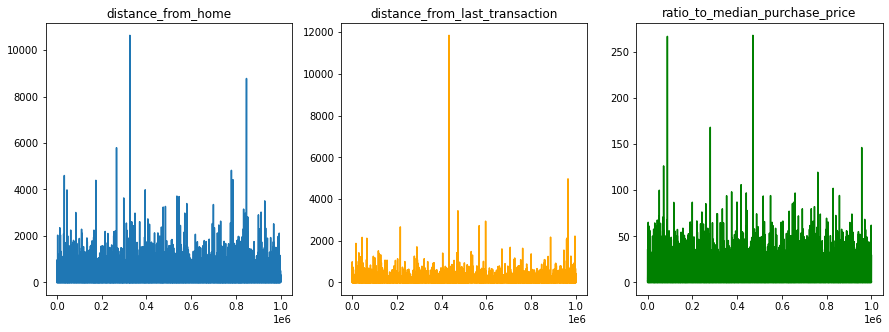

In [112]:
#vamos a ver los graficos de las caracteristicas por separado
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.set_title('distance_from_home')
ax1.plot(df_fraude_clean['distance_from_home'])
ax2.set_title('distance_from_last_transaction')
ax2.plot(df_fraude_clean['distance_from_last_transaction'],color='orange')
ax3.set_title('ratio_to_median_purchase_price')
ax3.plot(df_fraude_clean['ratio_to_median_purchase_price'],color='green')

plt.show()

In [278]:
#creamos el dataframe de features que vamos a utilizar y el de target
X = df_fraude_clean.drop(['fraud'],axis=1)
y = df_fraude_clean['fraud']

In [279]:
#creamos los grupos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [280]:
#instanciamos el modelo y lo entrenamos
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [281]:
#evaluamos el desempeño del modelo en el conjunto de prueba
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
print("AUC score:",roc_auc_score(y_test,y_test_pred)*100)

1.0
0.9999958002427459
AUC score: 99.9981028267881


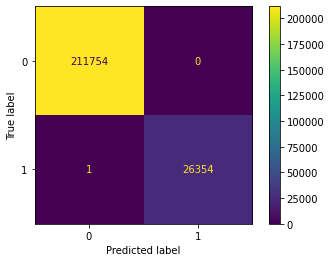

In [282]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

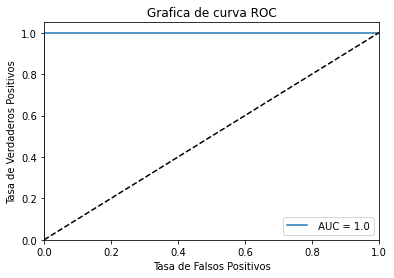

In [283]:
#Graficamos la curva ROC
y_test_pred = clf.predict_proba (X_test) [::, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc = roc_auc_score (y_test, y_test_pred)
plt.plot(fpr, tpr,label = " AUC = " + str (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Grafica de curva ROC')
plt.legend(loc="lower right")
plt.show()

### Que pasaria si solo tomamos las columnas que tienen correlacion positiva

In [284]:
X = df_fraude_clean[['distance_from_home' , 'distance_from_last_transaction', 'ratio_to_median_purchase_price','used_chip','online_order']]
y = df_fraude_clean['fraud']


In [285]:
#creamos los grupos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [286]:
#instanciamos el modelo y lo entrenamos
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [287]:
#evaluamos el desempeño del modelo en el conjunto de prueba
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
print("AUC score:",roc_auc_score(y_test,y_test_pred)*100)

1.0
0.9911469117085032
AUC score: 99.45740425946843


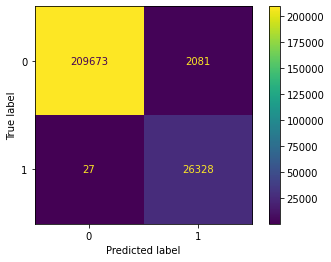

In [288]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

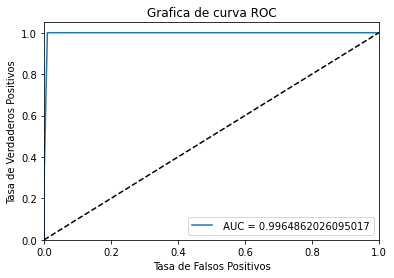

In [289]:
#Graficamos la curva ROC
y_test_pred = clf.predict_proba (X_test) [::, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc = roc_auc_score (y_test, y_test_pred)
plt.plot(fpr, tpr,label = " AUC = " + str (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Grafica de curva ROC')
plt.legend(loc="lower right")
plt.show()

Observamos que las escalas de las caracteristicas no son las mismas.
Que pasaria si escalamos los datos?

## 3- Escalando de los datos 

In [196]:
from sklearn.preprocessing import RobustScaler

Escalamos solo las filas que tienen correlacion positiva 

In [291]:
#Vamos a escalar los datos 
scaler = RobustScaler()
df_fraude_scal = scaler.fit_transform(df_fraude[['distance_from_home' , 'distance_from_last_transaction', 'ratio_to_median_purchase_price','used_chip','online_order','fraud']])



In [292]:
#paso los datos a un dataframe
df_fraude_scal = pd.DataFrame(df_fraude_scal, columns=['distance_from_home' , 'distance_from_last_transaction', 'ratio_to_median_purchase_price','used_chip','online_order','fraud'])

In [293]:
X = df_fraude_scal[['distance_from_home' , 'distance_from_last_transaction', 'ratio_to_median_purchase_price','used_chip','online_order']]
y = df_fraude_clean['fraud']

In [294]:
#instanciamos el modelo y lo entrenamos
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [295]:
#evaluamos el desempeño del modelo en el conjunto de prueba
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
print("AUC score:",roc_auc_score(y_test,y_test_pred)*100)

1.0
0.9911469117085032
AUC score: 99.45740425946843


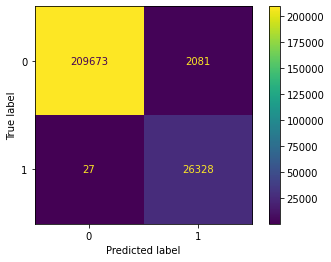

In [296]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

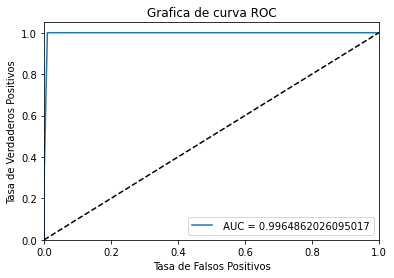

In [297]:
#Graficamos la curva ROC
y_test_pred = clf.predict_proba (X_test) [::, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc = roc_auc_score (y_test, y_test_pred)
plt.plot(fpr, tpr,label = " AUC = " + str (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Grafica de curva ROC')
plt.legend(loc="lower right")
plt.show()

## Ahora vamos a trabajar con todas las columnas del datset.

Primero sin escalar los datos del dataframe

In [313]:
X = df_fraude_clean.drop(['fraud'], axis=1)
y = df_fraude_clean['fraud']

In [314]:
#instanciamos el modelo y lo entrenamos
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [315]:
#evaluamos el desempeño del modelo en el conjunto de prueba
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
print("AUC score:",roc_auc_score(y_test,y_test_pred)*100)

1.0
0.9911469117085032
AUC score: 99.45740425946843


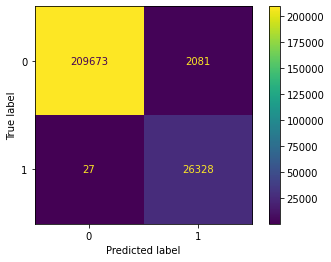

In [316]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

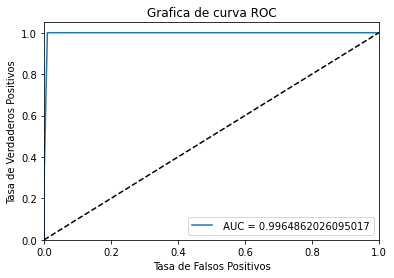

In [317]:
#Graficamos la curva ROC
y_test_pred = clf.predict_proba (X_test) [::, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc = roc_auc_score (y_test, y_test_pred)
plt.plot(fpr, tpr,label = " AUC = " + str (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Grafica de curva ROC')
plt.legend(loc="lower right")
plt.show()

Hahora vamos a escalar todo el dataset para verificar los resultados.

In [305]:
#Vamos a escalar los datos 
scaler = RobustScaler()
df_fraude_scal = scaler.fit_transform(df_fraude_clean)



In [306]:
#paso los datos a un dataframe
df_fraude_scal = pd.DataFrame(df_fraude_scal, columns=['distance_from_home' , 'distance_from_last_transaction', 
                                                'ratio_to_median_purchase_price', 'repeat_retailer',
                                                'used_chip','used_pin_number','online_order','fraud'])

In [307]:
df_fraude_scal.head(2)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.188398,-0.224748,0.515031,0.0,1.0,0.0,-1.0,0.0
1,0.039759,-0.268935,0.146321,0.0,0.0,0.0,-1.0,0.0


In [308]:
X = df_fraude_scal.drop(['fraud'], axis=1)
y = df_fraude_scal['fraud']

In [309]:
#instanciamos el modelo y lo entrenamos
clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [310]:
#evaluamos el desempeño del modelo en el conjunto de prueba
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
print("AUC score:",roc_auc_score(y_test,y_test_pred)*100)

1.0
0.9911469117085032
AUC score: 99.45740425946843


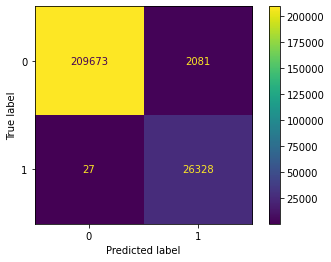

In [311]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

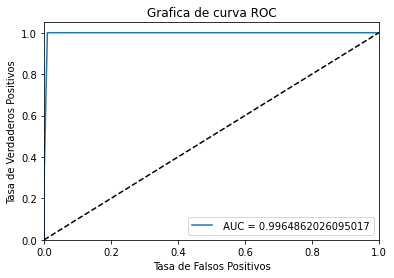

In [312]:
#Graficamos la curva ROC
y_test_pred = clf.predict_proba (X_test) [::, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc = roc_auc_score (y_test, y_test_pred)
plt.plot(fpr, tpr,label = " AUC = " + str (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Grafica de curva ROC')
plt.legend(loc="lower right")
plt.show()

CONCLUSION: El Accuracy promedio de las pruebas que realizamos es: 0.99557135597562455